In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from scipy.special import digamma, logsumexp
from utils import plot_confidence_ellipse


In [51]:
X = np.loadtxt('data/faithful.txt')
X = (X - X.mean(axis=0)) / X.std(axis=0)
N, D = X.shape  # n_samples, n_features

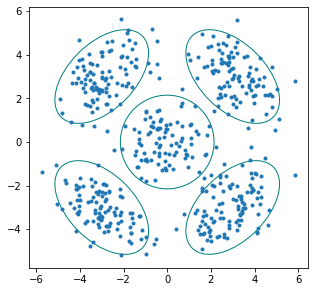

In [2]:
m_true = np.array([[0, 0], [3, -3], [3, 3], [-3, 3], [-3, -3]])
covs_true = np.array([[[1, 0], [0, 1]], [[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]], [[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]]])
X = np.concatenate([np.random.multivariate_normal(m_true[k], covs_true[k], 100) for k in range(len(m_true))])
N, D = X.shape

plt.figure(figsize=(5,5))
ax = plt.gca()
for k in range(len(m_true)):
    plot_confidence_ellipse(m_true[k], covs_true[k], 0.9, ax=ax, ec='teal')
plt.plot(*X.T, '.')
ax.set_aspect('equal')

In [40]:
K = 5

m0 = np.mean(X, axis=0)
# m = np.array([[-0.49813282, -0.78529033],
#        [0.3 , 0.3],
#        [ 0.16320506, -0.01819425]])
#        [-0.47266126, -0.68203894],
#        [ 0.38457508,  0.32323383],
#        [ 0.22959118,  0.10605733],
#        [ 0.06409906,  0.27213673],
#        [ 0.28301891,  0.29796192],
#        [ 0.13476758, -0.25260453],
#        [ 0.28530035, -0.00930441]])
m = np.zeros((K, D))

# beta0 = 1
# beta = beta0 * np.ones(K)

invW0 = np.cov(X.T)
W0 = np.linalg.inv(invW0)
W = np.array([np.cov(X[np.random.choice(N, 10)].T) for _ in range(K)])
# invW = np.array([invW0 for _ in range(K)])
# W = np.linalg.inv(invW)
# W0 = np.linalg.inv(invW0)
invW = np.linalg.inv(W)

beta0 = 1
invS0 = np.linalg.inv(beta0 * np.eye(D))
invS = np.array([invS0 for _ in range(K)])
# S = np.linalg.inv(invS)
# S0 = np.linalg.inv(invS0)

v0 = D
v = v0 * np.ones(K)

pi = np.ones(K) / K

resp = np.random.rand(N, K)
resp /= resp.sum(axis=1)[:, np.newaxis]

In [98]:
def init():
    global invW0, invW, resp, m, m0, beta0, invS0, invS, v0, v, pi
    m0 = np.mean(X, axis=0)
    m = X[np.random.choice(N, K)]
    invW0 = np.cov(X.T)
    W = np.array([np.cov(X[np.random.choice(N, 10)].T) for _ in range(K)])
    invW = np.linalg.inv(W)
    beta0 = 1
    invS0 = np.linalg.inv(beta0 * np.eye(D))
    invS = np.array([invS0 for _ in range(K)])
    v0 = K
    v = v0 * np.ones(K)
    pi = np.ones(K) / K
    resp = np.random.rand(N, K)
    resp /= resp.sum(axis=1)[:, np.newaxis]

In [7]:
def m_step():
    global pi
    pi = resp.sum(axis=0) / resp.sum()

In [23]:
def compute_exp():
    global exp_T, exp_log_det_T, exp_mu, exp_mu_muT
    exp_T = np.zeros_like(invW)
    exp_log_det_T = np.zeros(K)
    exp_mu = np.copy(m)
    exp_mu_muT = np.zeros_like(invS)
    for k in range(K):
        exp_T[k] = v[k] * invW[k]
        exp_log_det_T[k] = digamma(0.5*(v[k] - np.arange(D))).sum() + D * np.log(2) + np.log(np.linalg.det(invW[k]))
        exp_mu_muT[k] = invS[k] + np.outer(m[k], m[k])

In [64]:
def compute_resp():
    global resp
    log_rho = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            log_rho[n, k] = np.log(pi[k]+1e-15) + 0.5 * exp_log_det_T[k] - 0.5 * np.trace(
                exp_T[k] * (np.outer(X[n], X[n]) + np.outer(X[n], exp_mu[k]) + np.outer(exp_mu[k], X[n]) + exp_mu_muT[k])
            )
    log_resp = log_rho - logsumexp(log_rho, axis=1)[:, np.newaxis]
    resp = np.exp(log_resp)

In [10]:
def update_params():
    global m, invS, v, invW
    m = np.zeros_like(m)
    invS_old = np.copy(invS)
    invS = np.zeros_like(invS)
    v = np.zeros_like(v)
    invW = np.zeros_like(invW)

    for k in range(K):
        m[k] = invS_old[k] @ exp_T[k] @ (resp[:, k] @ X)
        invS[k] = np.linalg.inv(beta0 * np.eye(D) + exp_T[k] * resp[:, k].sum())
        v[k] = v0 + resp[:, k].sum()

        s = np.zeros((D, D))
        for n in range(N):
            s += resp[n, k] * (np.outer(X[n], X[n]) + np.outer(X[n], exp_mu[k]) + np.outer(exp_mu[k], X[n]) + exp_mu_muT[k])
        invW[k] = np.linalg.inv(W0 + s)

In [59]:
def display():
    plt.figure(figsize=(6,6))
    plt.plot(*X.T, 'o', c='dimgrey', alpha = 0.5)
    ax = plt.gca()
    for k in range(K):
        if pi[k] >= 1/(2*K):
            plot_confidence_ellipse(m[k],np.linalg.inv(invW[k])/v[k], 0.9, ax=ax, ec='teal')
    ax.set_aspect('equal')
    plt.show()

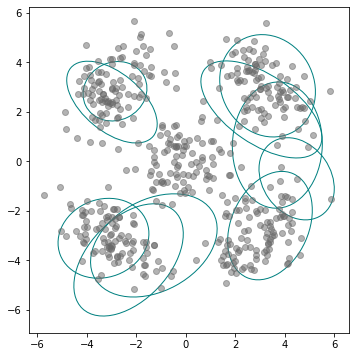

0


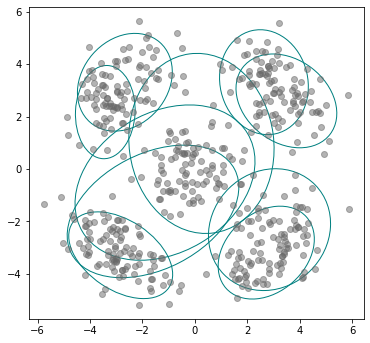

10


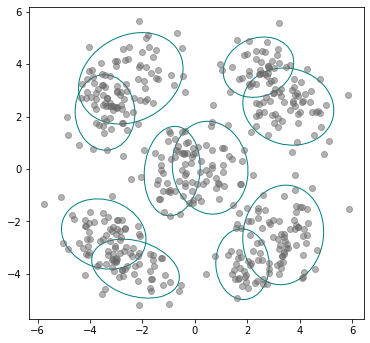

20


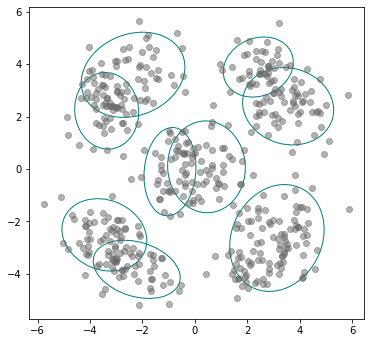

30


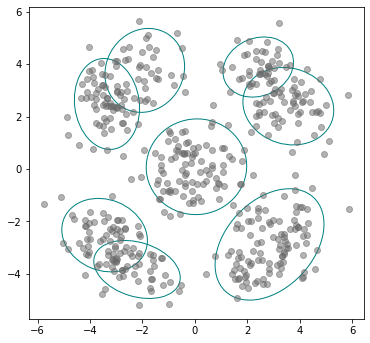

40


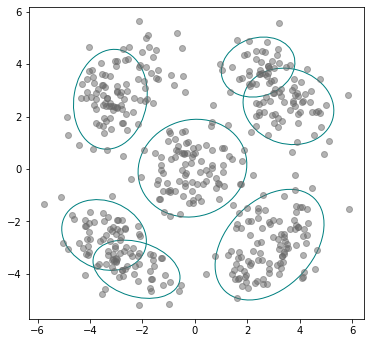

50


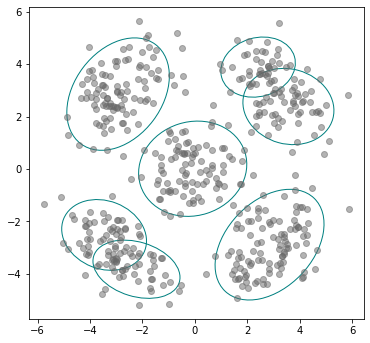

60


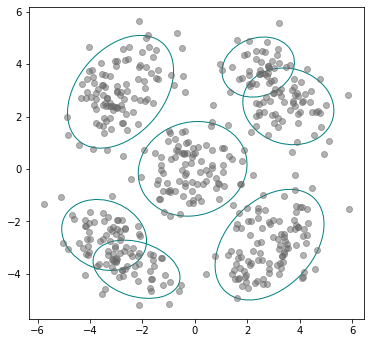

70


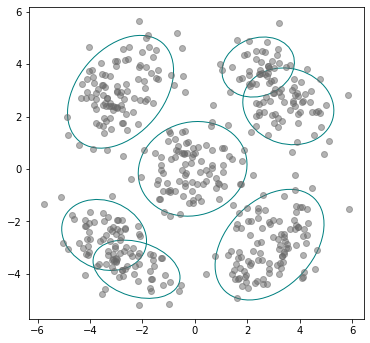

80


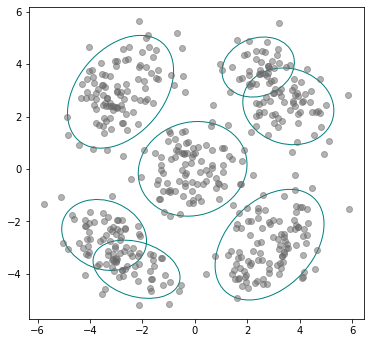

KeyboardInterrupt: 

In [101]:
K = 10
init()
display()
# compute_exp()
# update_params()
# update_params()
# display()

for i in range(300):
    for _ in range(3):
        compute_exp()
        compute_resp()
        update_params()
        update_params()
    m_step()
    if i%10 == 0:
        print(i)
        display()